In [89]:
import pandas as pd, numpy as np, datetime
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt


from sklearn.ensemble import IsolationForest

import random
random.seed(21)
import time
import folium

In [2]:
ecanter_june = pd.read_csv("/home/173190004/mtp/data/ecanter_june.csv")

In [3]:
#ecanter_june.describe()

ecanter_june.drop(["tt","salt"],axis=1,inplace=True)

#type(ecanter_june)

#ecanter_june.dtypes

#type(ecanter_june["stime"])

ecanter_june['stime'] = pd.to_datetime(ecanter_june['stime'],unit='ms')

ecanter_june.sort_values(["vin","stime"],axis=0,inplace=True)

In [4]:
start = time.time()

vehicle_no = ecanter_june["vin"].unique().tolist()

#print(vehicle_no[0])

#print(len(vehicle_no))

veh_sep_large = []
for i in range(len(vehicle_no)):
    vin_file = ecanter_june[ecanter_june["vin"]==vehicle_no[i]]
    vin_file.sort_values(["stime"],axis=0,inplace=True)
    vin_file.reset_index(drop=True, inplace=True)
    veh_sep_large.append(vin_file) 
    #filename = "/home/173190004/mtp/work/Python  work/vehicle seperation/sep_1/vin_"+str(i+1)+".csv"
    #vin_file.to_csv(filename,index=False)

end = time.time()
print(end-start)

#print(len(veh_sep_large))
#print(veh_sep_large[1].isnull().sum())

9.225685119628906


In [5]:
veh_sep_small = []
for i in range(len(vehicle_no)):
    veh_sep_small.append(veh_sep_large[i].drop(["alt","bwh","lat","head","long","speed","region","vin"],axis=1))
    veh_sep_small[i].dropna(subset=['bcl','tvd'],how='all',inplace=True)
    
    
#len(veh_sep_small)

In [6]:
start = time.time()

tvd_notnull_all_0 = []
for i in range(len(vehicle_no)):
    tvd_notnull_all_0.append(veh_sep_large[i].drop(["alt","bwh","lat","head","long","speed","region","vin"],axis=1))
    tvd_notnull_all_0[i]= tvd_notnull_all_0[i].dropna(subset=['tvd'])
    
end = time.time()
print(end-start)

0.579998254776001


In [7]:
stationary_index_all = []
for j in range(len(vehicle_no)):
    

    indx=tvd_notnull_all_0[j].index.values
    stationary_time_indexes=[]
    for i in range(1,(len(indx)-1)):    
        
        br = tvd_notnull_all_0[j]["tvd"].iloc[i-1]
        cr = tvd_notnull_all_0[j]["tvd"].iloc[i]
        nr = tvd_notnull_all_0[j]["tvd"].iloc[i+1]
        
        if nr == cr:
        
            if cr > br:
                r = range(indx[i]+1,(indx[i+1]))
                stationary_time_indexes.append(list(r))
        
            else:
                r = range(indx[i],(indx[i+1]))
                stationary_time_indexes.append(list(r))
                
                
    stationary_index_all.append(stationary_time_indexes)

In [8]:
start = time.time()
moving_all_1 = [[] for i in range(len(vehicle_no))]

for j in range(len(vehicle_no)):
    
    flattened_list = [y for x in stationary_index_all[j] for y in x]
    
    indexes_to_keep = set(range(len(veh_sep_large[j]))) - set(flattened_list)

    moving_all_1[j] = veh_sep_large[j].loc[list(indexes_to_keep),["stime","bcl","tvd"]]
    
    moving_all_1[j].sort_index(inplace=True)
    
end = time.time()
print(end-start)

5.080359935760498


In [9]:
print(stationary_index_all[8][7])

[129, 130, 131, 132, 133, 134, 135, 136, 137, 138]


In [10]:
bcl_notnull_all_1 = []
for i in range(len(vehicle_no)):
    bcl_notnull_all_1.append(moving_all_1[i])
    bcl_notnull_all_1[i] = bcl_notnull_all_1[i].dropna(subset=['bcl'])

In [11]:
start = time.time()

bcl_noise_index_all = []

for j in range(len(vehicle_no)):

    indx = bcl_notnull_all_1[j].index.values
    noise_indexes=[]

    for i in range(1,(len(indx)-1)):
        br = bcl_notnull_all_1[j]["bcl"].iloc[i-1]
        cr = bcl_notnull_all_1[j]["bcl"].iloc[i]
        nr = bcl_notnull_all_1[j]["bcl"].iloc[i+1]

        if cr==0:
            r = range(indx[i],indx[i+1])
            noise_indexes.append(list(r))
        
        
        elif (cr-2) > nr:
            if br > (1+cr) or br < cr:
                r = range(indx[i],indx[i+1])
                noise_indexes.append(list(r))
            else:
                r = range(indx[i]+1,indx[i+1])
                noise_indexes.append(list(r))

        elif cr < nr:
            if br>=cr and cr >= (br-2):
                r = range(indx[i]+1,indx[i+1])
                noise_indexes.append(list(r))

            else:
                r = range(indx[i],indx[i+1])
                noise_indexes.append(list(r))




    bcl_noise_index_all.append(noise_indexes)
    
end = time.time()
print(end-start)

17.552884578704834


In [13]:
start = time.time()
moving_all_2 = []
all_cleaned_data_2 = []



for j in range(len(vehicle_no)):
    
    moving_all_2.append(veh_sep_large[j].drop(["alt","bwh","lat","head","long","speed","region","vin"],axis=1))
    
    flattened_list = [y for x in bcl_noise_index_all[j] for y in x]
    
    set(moving_all_1[j].index.values)
    indexes_to_keep = set(moving_all_1[j].index.values) - set(flattened_list)

    moving_all_2[j] = moving_all_2[j].take(list(indexes_to_keep))
    moving_all_2[j].sort_index(inplace=True)
    all_cleaned_data_2.append(veh_sep_large[j])
    all_cleaned_data_2[j] = all_cleaned_data_2[j].take(list(indexes_to_keep))
    all_cleaned_data_2[j].sort_index(inplace=True)
    
    
    
    
    
end = time.time()
print(end-start)

10.078767776489258


In [113]:
moving_all_2_wo_null=[]
bcl_notnull_all_2 = []
tvd_notnull_all_2 = []
gps_notnull_all_2 = []

gps_notnull_all_0 = []


for j in range(len(vehicle_no)):
    moving_all_2_wo_null.append(moving_all_2[j].dropna(subset=['bcl','tvd'],how='all'))
    bcl_notnull_all_2.append(moving_all_2[j].dropna(subset=['bcl']))
    tvd_notnull_all_2.append(moving_all_2[j].dropna(subset=['tvd']))
    gps_notnull_all_2.append(all_cleaned_data_2[j].dropna(subset=['lat','long'],how='any'))
    gps_notnull_all_0.append(veh_sep_large[j].dropna(subset=['lat','long'],how='any'))

In [52]:
len(gps_notnull_all_2[1])

106037

In [48]:
len(veh_sep_large[0])

112807

In [49]:
len(all_cleaned_data_2[0])

69854

In [53]:
all_cleaned_data_2[0].head(10)

,stime,region,vin,alt,bcl,bwh,lat,head,long,tvd,speed
0,2018-06-01 00:08:53,JP,354476053748871,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-06-01 00:08:55,JP,354476053748871,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-06-01 00:09:37,JP,354476053748871,-90.071910,NaN,NaN,35.664160,230.838300,139.92583,NaN,0.993837
4,2018-06-01 00:09:38,JP,354476053748871,-89.894905,NaN,NaN,35.664070,84.764300,139.92586,NaN,0.827288
5,2018-06-01 00:09:41,JP,354476053748871,-85.063960,NaN,NaN,35.664085,47.845108,139.92595,NaN,0.841776
6,2018-06-01 00:09:44,JP,354476053748871,-81.096070,NaN,NaN,35.664104,62.425860,139.92601,NaN,0.751546
7,2018-06-01 00:09:47,JP,354476053748871,-75.922800,NaN,NaN,35.664060,123.715150,139.92609,NaN,0.784484
8,2018-06-01 00:09:51,JP,354476053748871,-72.354904,NaN,NaN,35.664032,132.849730,139.92613,NaN,0.348488
9,2018-06-01 00:09:54,JP,354476053748871,-67.598000,NaN,NaN,35.664010,116.493560,139.92620,NaN,0.280617
10,2018-06-01 00:09:55,JP,354476053748871,NaN,100.0,NaN,NaN,NaN,NaN,1928685.0,NaN


In [107]:
gps_notnull_all_2[1].head(10)

,stime,region,vin,alt,bcl,bwh,lat,head,long,tvd,speed
8,2018-06-01 00:00:10,JP,354476053749283,0.346649,NaN,NaN,35.626747,294.51517,139.78506,NaN,0.586067
11,2018-06-01 00:00:22,JP,354476053749283,0.346649,NaN,NaN,35.626747,267.91043,139.78506,3154535.0,0.279827
14,2018-06-01 00:00:32,JP,354476053749283,0.346649,NaN,NaN,35.626747,252.78940,139.78506,NaN,0.184806
17,2018-06-01 00:00:43,JP,354476053749283,0.346649,NaN,NaN,35.626747,228.69640,139.78506,NaN,0.158803
21,2018-06-01 00:00:55,JP,354476053749283,0.346649,NaN,NaN,35.626747,216.62308,139.78506,NaN,0.138155
25,2018-06-01 00:01:05,JP,354476053749283,0.346649,NaN,NaN,35.626747,268.54633,139.78506,NaN,0.073429
28,2018-06-01 00:01:17,JP,354476053749283,0.346649,NaN,NaN,35.626747,134.05672,139.78506,NaN,0.140808
31,2018-06-01 00:01:27,JP,354476053749283,0.346649,NaN,NaN,35.626747,210.76752,139.78506,NaN,0.742150
33,2018-06-01 00:01:32,JP,354476053749283,0.224806,NaN,NaN,35.626717,239.10095,139.78500,NaN,15.135504
34,2018-06-01 00:01:33,JP,354476053749283,0.088790,NaN,NaN,35.626694,237.94370,139.78494,NaN,15.927449


In [88]:
type(gps_notnull_all_2[0]["lat"])

pandas.core.series.Series

In [106]:
len(gps_notnull_all_2[1])

106037

In [119]:
m = folium.Map(location=[gps_notnull_all_0[0]["lat"].iloc[0], gps_notnull_all_0[0]["long"].iloc[0]], zoom_start=14)

gps_list = []

for i in range(18000):
    gps_list.append([gps_notnull_all_0[0]["lat"].iloc[i],gps_notnull_all_0[0]["long"].iloc[i]])



folium.PolyLine(locations=gps_list).add_to(m)
m

In [75]:
import folium


m = folium.Map(location=[35.664160, 139.92583], zoom_start=14)
for i in range(2500):
    folium.Marker(location=[gps_notnull_all_2[0]["lat"].iloc[i], gps_notnull_all_2[0]["long"].iloc[i]]).add_to(m)
m

In [19]:
v = 13

In [20]:

print(len(veh_sep_large[v]["tvd"].unique()))
print(len(veh_sep_small[v]["tvd"].unique()))
print(len(moving_all_1[v]["tvd"].unique()))
print(len(moving_all_2[v]["tvd"].unique()))

1036
1036
1036
876


In [21]:
#v = 8

print(veh_sep_large[v].shape)
#print(veh_sep_large[v].head(7))
#print(veh_sep_large[v].tail(7))
#(veh_sep_large[v].notnull().sum())

(50565, 11)


In [22]:
#v = 8

print(veh_sep_small[v].shape)
print(veh_sep_small[v].head())
print(veh_sep_small[v].tail())
veh_sep_small[v].notnull().sum()

(3852, 3)
                 stime    bcl        tvd
3  2018-06-01 05:33:04    1.0        NaN
4  2018-06-01 05:33:05   21.0  1348760.0
5  2018-06-01 05:33:06  100.0        NaN
8  2018-06-01 05:33:16  100.0        NaN
41 2018-06-01 05:34:10    NaN  1348915.0
                    stime    bcl        tvd
50518 2018-07-06 05:45:18  100.0  1599985.0
50519 2018-07-06 05:45:19  100.0        NaN
50523 2018-07-06 05:45:32    0.0        NaN
50524 2018-07-06 05:45:33    0.0        NaN
50525 2018-07-06 05:45:34    0.0        NaN


stime    3852
bcl      2567
tvd      1633
dtype: int64

In [23]:
print(moving_all_1[v].shape)
print(moving_all_1[v].head())
print(moving_all_1[v].dropna(subset=['bcl','tvd'],how='all').shape)
moving_all_1[v].dropna(subset=['bcl','tvd'],how='all').head()

(41105, 3)
                stime   bcl        tvd
0 2018-06-01 05:32:57   NaN        NaN
1 2018-06-01 05:33:00   NaN        NaN
2 2018-06-01 05:33:02   NaN        NaN
3 2018-06-01 05:33:04   1.0        NaN
4 2018-06-01 05:33:05  21.0  1348760.0
(2852, 3)


,stime,bcl,tvd
3,2018-06-01 05:33:04,1.0,NaN
4,2018-06-01 05:33:05,21.0,1348760.0
5,2018-06-01 05:33:06,100.0,NaN
8,2018-06-01 05:33:16,100.0,NaN
41,2018-06-01 05:34:10,NaN,1348915.0


In [24]:
print(moving_all_2[v].shape)
print(moving_all_2[v].head())
print(moving_all_2[v].dropna(subset=['bcl','tvd'],how='all').shape)
moving_all_2[v].dropna(subset=['bcl','tvd'],how='all').head()

(36407, 3)
                stime    bcl  tvd
0 2018-06-01 05:32:57    NaN  NaN
1 2018-06-01 05:33:00    NaN  NaN
2 2018-06-01 05:33:02    NaN  NaN
3 2018-06-01 05:33:04    1.0  NaN
5 2018-06-01 05:33:06  100.0  NaN
(2259, 3)


,stime,bcl,tvd
3,2018-06-01 05:33:04,1.0,NaN
5,2018-06-01 05:33:06,100.0,NaN
8,2018-06-01 05:33:16,100.0,NaN
168,2018-06-01 07:19:00,100.0,1348920.0
180,2018-06-01 07:22:42,NaN,1348920.0


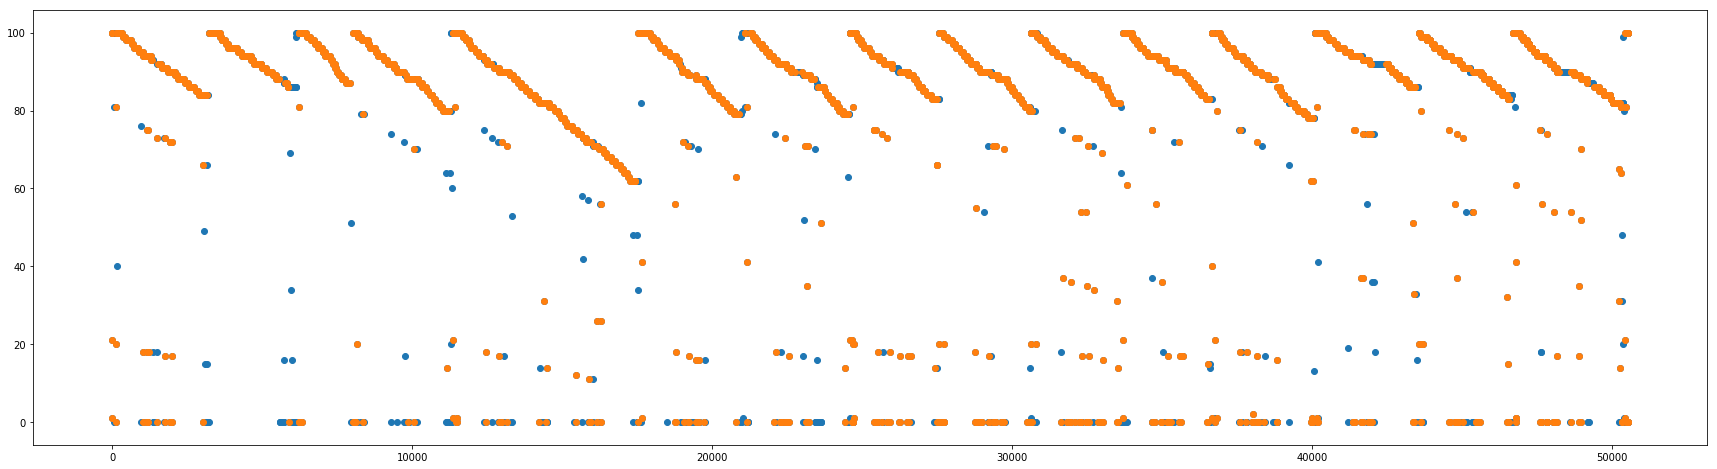

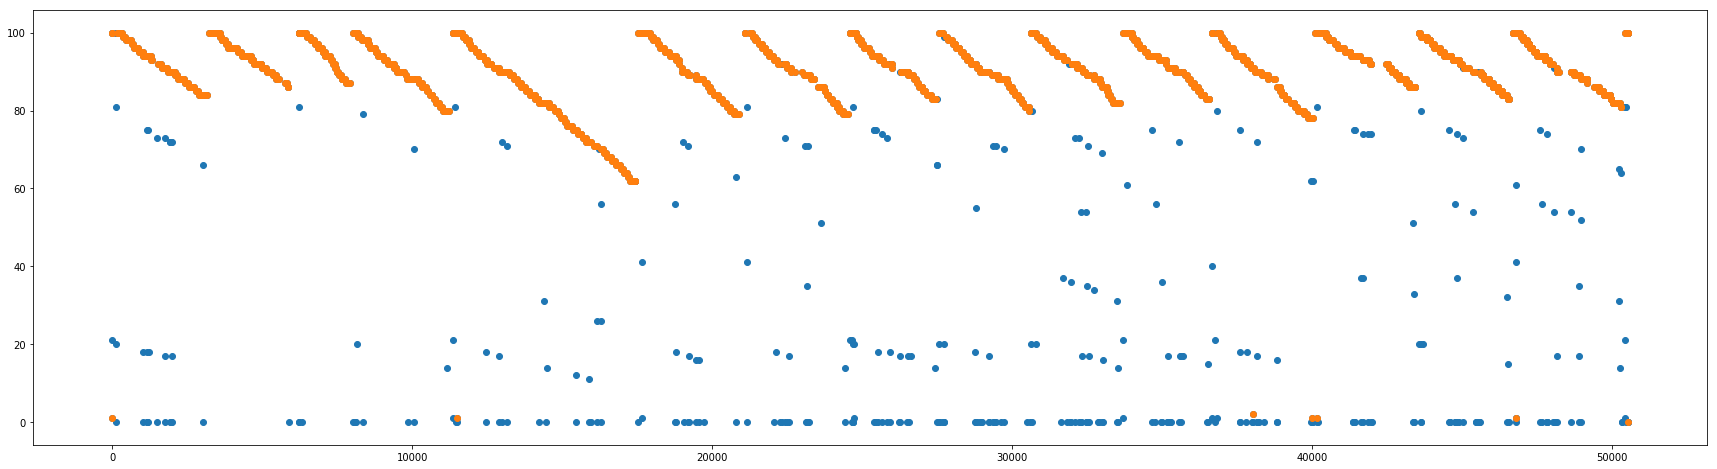

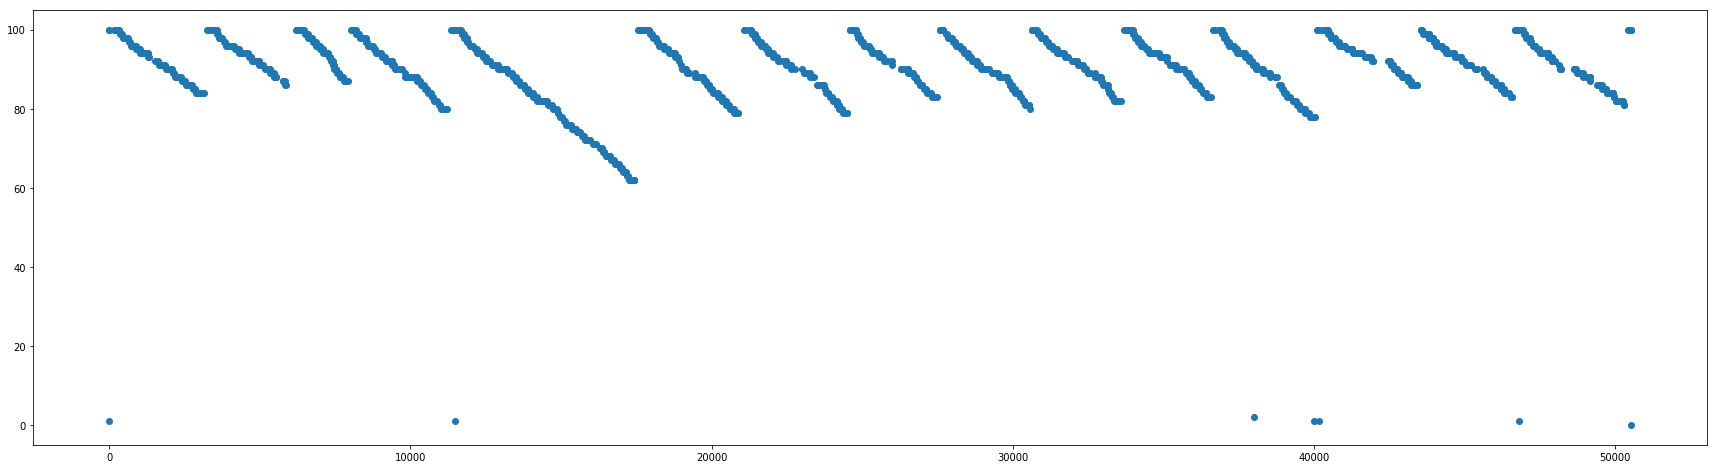

In [25]:
plt.figure(1,figsize=(30,8))
plt.scatter(veh_sep_small[v].index,veh_sep_small[v]["bcl"])


plt.figure(1,figsize=(30,8))
plt.scatter(moving_all_1[v].index,moving_all_1[v]["bcl"])

plt.figure(2,figsize=(30,8))
plt.scatter(moving_all_1[v].index,moving_all_1[v]["bcl"])

plt.figure(2,figsize=(30,8))
plt.scatter(moving_all_2[v].index,moving_all_2[v]["bcl"])

plt.figure(3,figsize=(30,8))
plt.scatter(moving_all_2[v].index,moving_all_2[v]["bcl"])


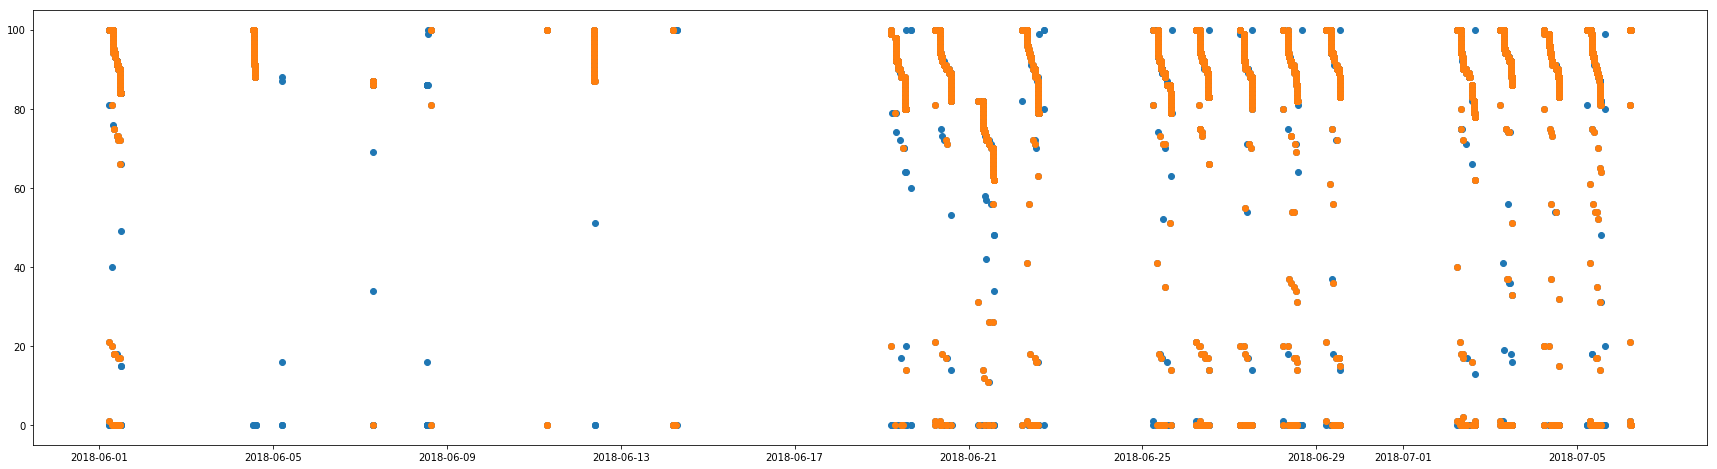

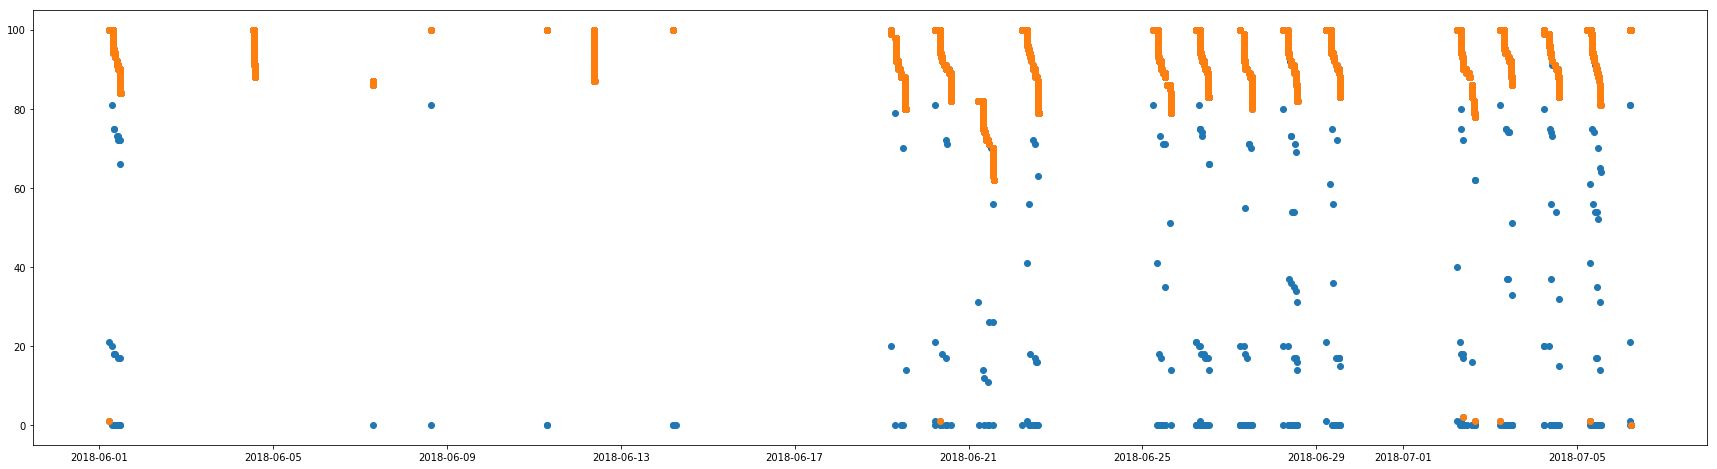

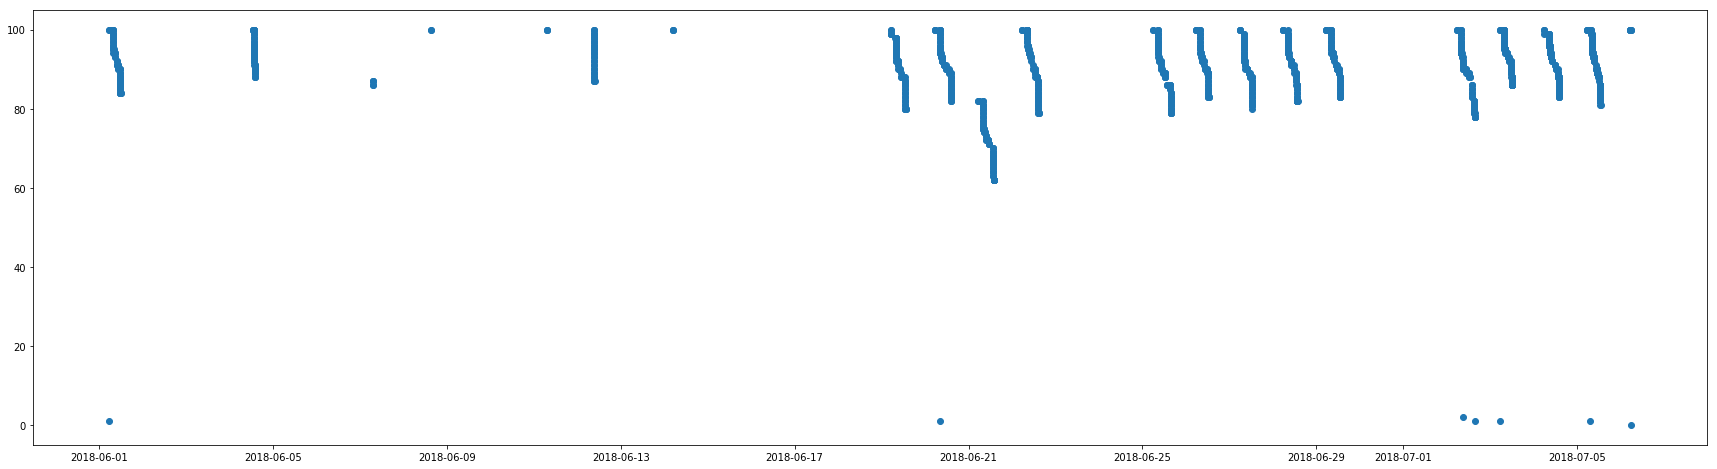

In [26]:

plt.figure(1,figsize=(30,8))
plt.plot_date(veh_sep_small[v]["stime"],veh_sep_small[v]["bcl"])

plt.figure(1,figsize=(30,8))
plt.plot_date(moving_all_1[v]["stime"],moving_all_1[v]["bcl"])

plt.figure(2,figsize=(30,8))
plt.plot_date(moving_all_1[v]["stime"],moving_all_1[v]["bcl"])


plt.figure(2,figsize=(30,8))
plt.plot_date(moving_all_2[v]["stime"],moving_all_2[v]["bcl"])


plt.figure(3,figsize=(30,8))
plt.plot_date(moving_all_2[v]["stime"],moving_all_2[v]["bcl"])

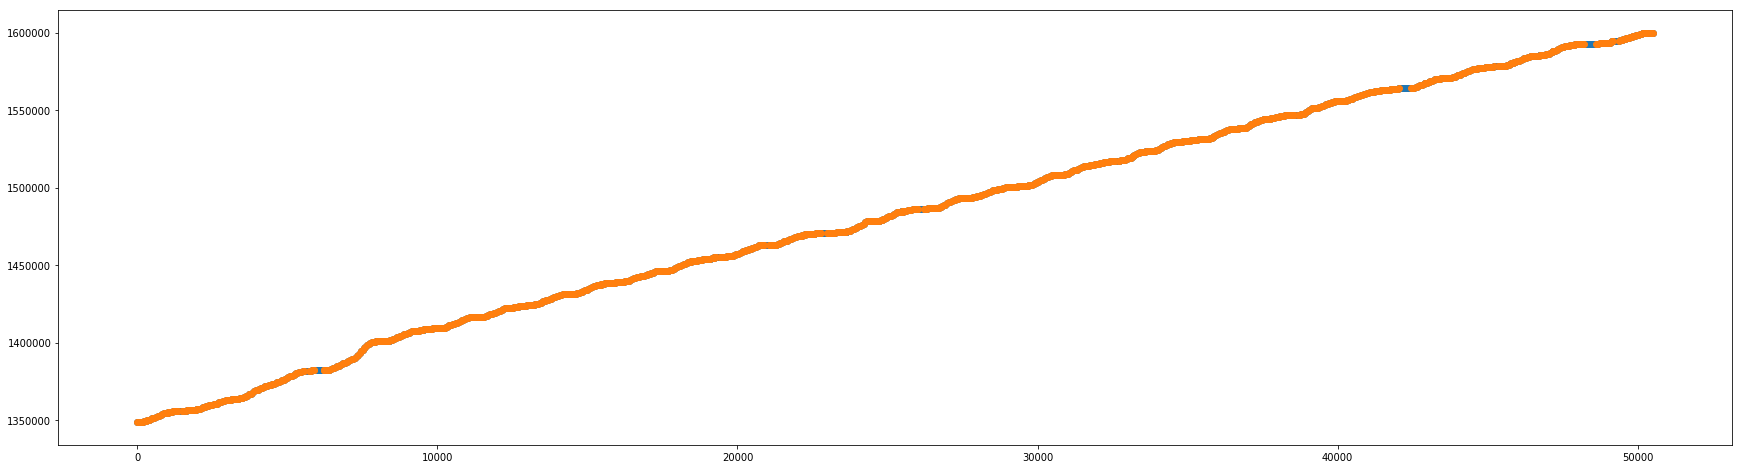

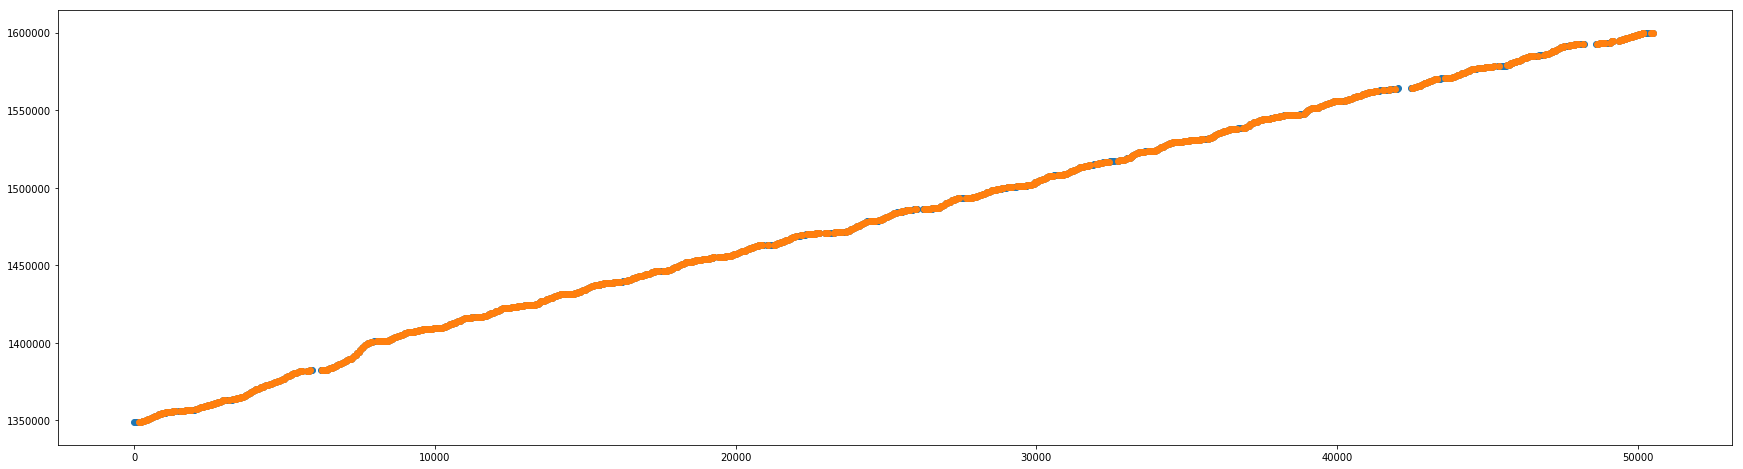

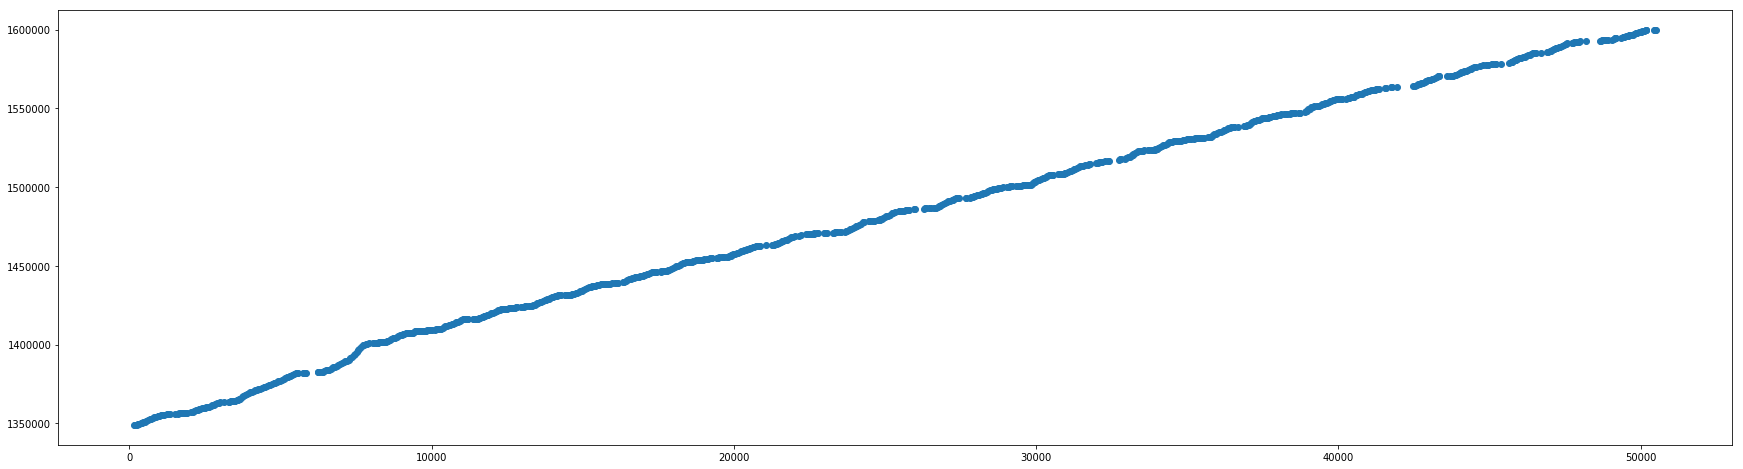

In [27]:

plt.figure(1,figsize=(30,8))
plt.scatter(veh_sep_small[v].index,veh_sep_small[v]["tvd"])


plt.figure(1,figsize=(30,8))
plt.scatter(moving_all_1[v].index,moving_all_1[v]["tvd"])


plt.figure(2,figsize=(30,8))
plt.scatter(moving_all_1[v].index,moving_all_1[v]["tvd"])

plt.figure(2,figsize=(30,8))
plt.scatter(moving_all_2[v].index,moving_all_2[v]["tvd"])

plt.figure(3,figsize=(30,8))
plt.scatter(moving_all_2[v].index,moving_all_2[v]["tvd"])

#plt.savefig("plots/")

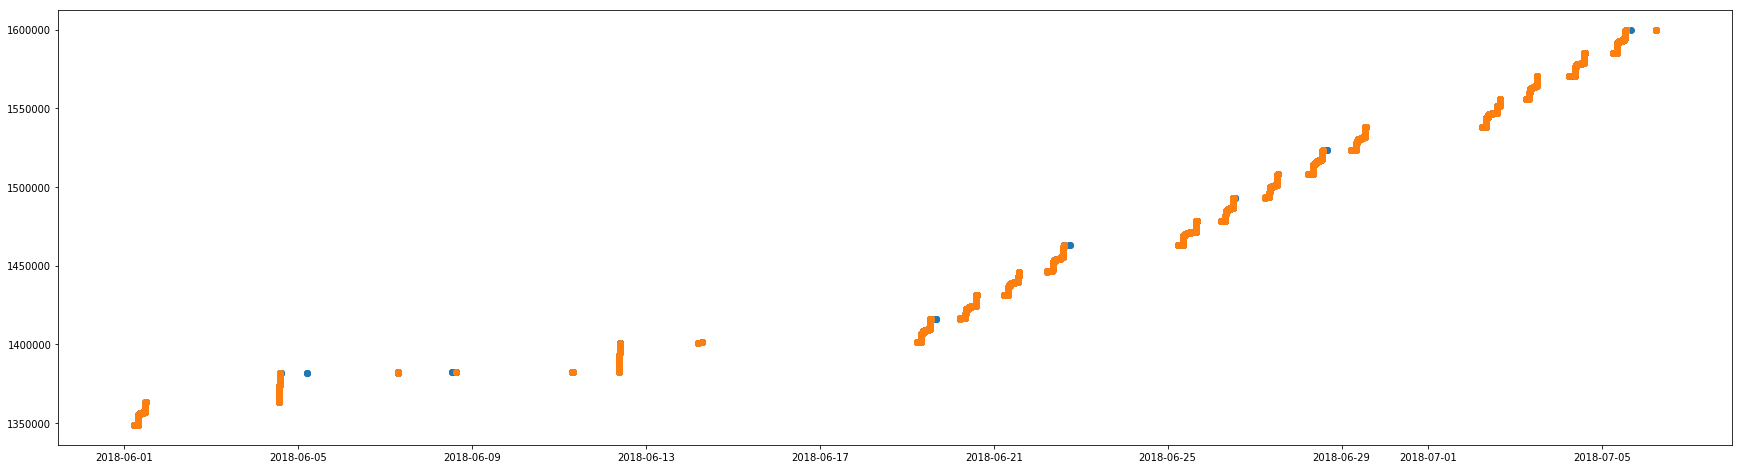

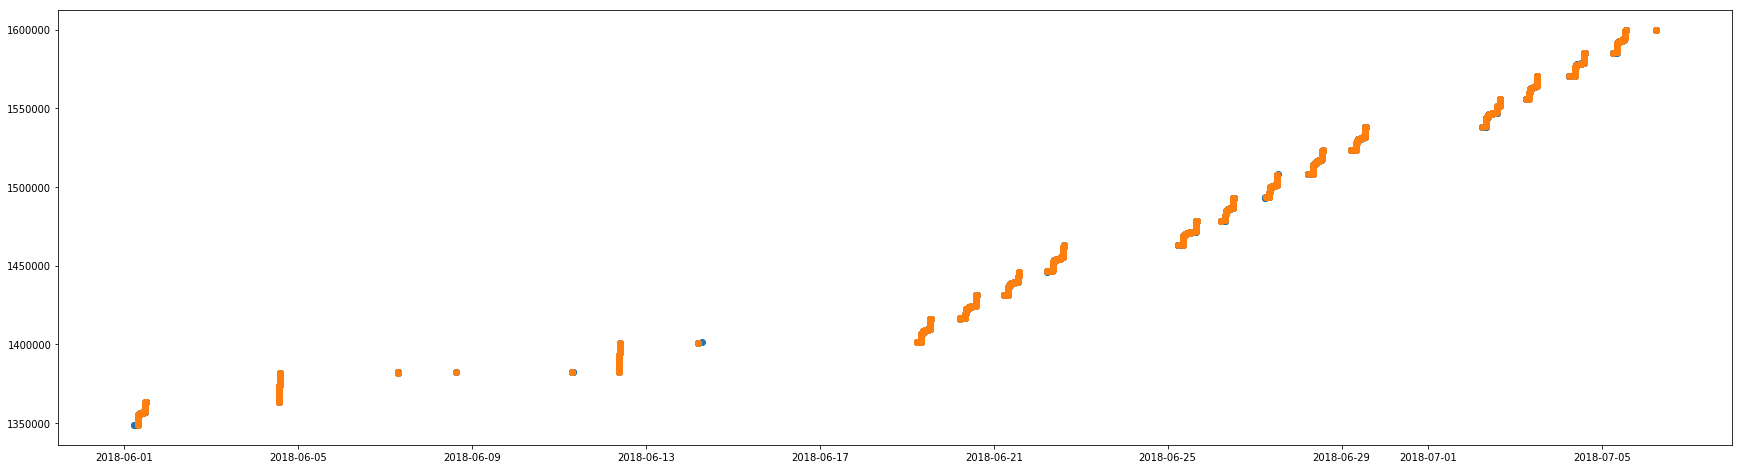

In [28]:

plt.figure(1,figsize=(30,8))
plt.plot_date(veh_sep_small[v]["stime"],veh_sep_small[v]["tvd"])

plt.figure(1,figsize=(30,8))
plt.plot_date(moving_all_1[v]["stime"],moving_all_1[v]["tvd"])

plt.figure(2,figsize=(30,8))
plt.plot_date(moving_all_1[v]["stime"],moving_all_1[v]["tvd"])

plt.figure(2,figsize=(30,8))
plt.plot_date(moving_all_2[v]["stime"],moving_all_2[v]["tvd"])

In [29]:

slab_1_u = 70
slab_1_l = 60
slab_2_u = 60
slab_2_l = 50
slab_3_u = 50
slab_3_l = 45


trip_set_slab_1 = []
trip_set_slab_2 = []
trip_set_slab_3 = []


for j in range(len(vehicle_no)):

    idx_bcl = bcl_notnull_all_2[j].index.values
    
    
    cycle_slab_1 = []
    cycle_slab_2 = []
    cycle_slab_3 = []
    
    set_a = set()
    set_b = set()
    set_c = set()
    

    for i in range(len(idx_bcl)-1):
        
        pbr = bcl_notnull_all_2[j]["bcl"].iloc[i-1]
        cbr = bcl_notnull_all_2[j]["bcl"].iloc[i]
        nbr = bcl_notnull_all_2[j]["bcl"].iloc[i+1]
        
        if slab_1_u >= cbr and cbr > slab_1_l:
            
            if cbr+1 >= nbr and cbr-1 <= nbr:
                set_a |= set([idx_bcl[i],idx_bcl[i+1]])

            else:
                if set_a != set():
                    cycle_slab_1.append(list(set_a))
                    set_a = set()
                    
        elif cbr == slab_1_l:
            if set_a != set():
                cycle_slab_1.append(list(set_a))
                set_a = set()
                
        
        
        if slab_2_u >= cbr and cbr > slab_2_l:                
            
            if cbr+1 >= nbr and cbr-1 <= nbr:
                set_b |= set([idx_bcl[i],idx_bcl[i+1]])

            else:
                if set_b != set():
                    cycle_slab_2.append(list(set_b))
                    set_b = set()                
          
        elif cbr == slab_2_l:
            if set_b != set():
                cycle_slab_2.append(list(set_b))
                set_b = set()
                
        
        
        if slab_3_u >= cbr and cbr > slab_3_l:                
            
            if cbr+1 >= nbr and cbr-1 <= nbr:
                set_c |= set([idx_bcl[i],idx_bcl[i+1]])

            else:
                if set_c != set():
                    cycle_slab_3.append(list(set_c))
                    set_c = set()                
          
        elif cbr == slab_3_l:
            if set_c != set():
                cycle_slab_3.append(list(set_c))
                set_c = set()
            
    
    trip_set_slab_1.append(cycle_slab_1)
    trip_set_slab_2.append(cycle_slab_2)
    trip_set_slab_3.append(cycle_slab_3)
    
    
    
    #trip_set_lower.append(cycle_lower)


tot_dist_all_slab_1 = 0
tot_dist_all_slab_2 = 0
tot_dist_all_slab_3 = 0


tot_btry_all_slab_1 = 0
tot_btry_all_slab_2 = 0
tot_btry_all_slab_3 = 0



btry_cycle_length = []


#btry_dist_veh_slab_1 = []
#btry_dist_veh_slab_2 = []
#btry_dist_veh_slab_3 = []

for j in range(len(vehicle_no)):  
    #print(j)
    
    tot_dist_veh_slab_1 = 0
    tot_dist_veh_slab_2 = 0
    tot_dist_veh_slab_3 = 0
    
    tot_btry_veh_slab_1 = 0
    tot_btry_veh_slab_2 = 0
    tot_btry_veh_slab_3 = 0
    
    
    
    for i in range(len(trip_set_slab_1[j])):
        
        #print(i)
        max_ind = max(trip_set_slab_1[j][i])
        min_ind = min(trip_set_slab_1[j][i])
        #print(min_ind,max_ind)

        max_tvd = max(tvd_notnull_all_2[j].loc[(min_ind-35):(max_ind+40),"tvd"],default = 0)
        min_tvd = min(tvd_notnull_all_2[j].loc[(min_ind-35):(max_ind+40),"tvd"],default = 0)
        #print(min_tvd,max_tvd)


        dist_in_a_trip = max_tvd - min_tvd
        btry_in_a_trip = bcl_notnull_all_2[j].loc[min_ind,"bcl"] - bcl_notnull_all_2[j].loc[max_ind,"bcl"]

        btry_cycle_length.append(btry_in_a_trip)
        
        tot_dist_veh_slab_1 += dist_in_a_trip
        tot_btry_veh_slab_1 += btry_in_a_trip
    
    #print(tot_dist_veh)
    #print(tot_btry_veh)
    tot_dist_all_slab_1 += tot_dist_veh_slab_1
    tot_btry_all_slab_1 += tot_btry_veh_slab_1
    
    #btry_dist_veh_slab_1.append([tot_dist_veh_slab_1,tot_btry_veh_slab_1])
    

#print(tot_dist_all_upper)
#print(tot_btry_all_upper)

    for i in range(len(trip_set_slab_2[j])):
        
        max_ind = max(trip_set_slab_2[j][i])
        min_ind = min(trip_set_slab_2[j][i])
        #print(min_ind,max_ind)

        max_tvd = max(tvd_notnull_all_2[j].loc[(min_ind-35):(max_ind+40),"tvd"],default = 0)
        min_tvd = min(tvd_notnull_all_2[j].loc[(min_ind-35):(max_ind+40),"tvd"],default = 0)
        #print(min_tvd,max_tvd)


        dist_in_a_trip = max_tvd - min_tvd
        btry_in_a_trip = bcl_notnull_all_2[j].loc[min_ind,"bcl"] - bcl_notnull_all_2[j].loc[max_ind,"bcl"]

        btry_cycle_length.append(btry_in_a_trip)
        
        tot_dist_veh_slab_2 += dist_in_a_trip
        tot_btry_veh_slab_2 += btry_in_a_trip
    
    #print(tot_dist_veh)
    #print(tot_btry_veh)
    tot_dist_all_slab_2 += tot_dist_veh_slab_2
    tot_btry_all_slab_2 += tot_btry_veh_slab_2
    
    
    
    for i in range(len(trip_set_slab_3[j])):
        
        max_ind = max(trip_set_slab_3[j][i])
        min_ind = min(trip_set_slab_3[j][i])
        #print(min_ind,max_ind)

        max_tvd = max(tvd_notnull_all_2[j].loc[(min_ind-35):(max_ind+40),"tvd"],default = 0)
        min_tvd = min(tvd_notnull_all_2[j].loc[(min_ind-35):(max_ind+40),"tvd"],default = 0)
        #print(min_tvd,max_tvd)


        dist_in_a_trip = max_tvd - min_tvd
        btry_in_a_trip = bcl_notnull_all_2[j].loc[min_ind,"bcl"] - bcl_notnull_all_2[j].loc[max_ind,"bcl"]

        btry_cycle_length.append(btry_in_a_trip)
        
        tot_dist_veh_slab_3 += dist_in_a_trip
        tot_btry_veh_slab_3 += btry_in_a_trip
    
    #print(tot_dist_veh)
    #print(tot_btry_veh)
    tot_dist_all_slab_3 += tot_dist_veh_slab_3
    tot_btry_all_slab_3 += tot_btry_veh_slab_3

    

    
print(tot_dist_all_slab_1,tot_dist_all_slab_2,tot_dist_all_slab_3)
print(tot_btry_all_slab_1,tot_btry_all_slab_2,tot_btry_all_slab_3)


eff_overall = (tot_dist_all_slab_1+tot_dist_all_slab_2+tot_dist_all_slab_3)/(tot_btry_all_slab_1+tot_btry_all_slab_2+tot_btry_all_slab_3)

eff_slab_1 = tot_dist_all_slab_1/tot_btry_all_slab_1
eff_slab_2 = tot_dist_all_slab_2/tot_btry_all_slab_2
eff_slab_3 = tot_dist_all_slab_3/tot_btry_all_slab_3


print(eff_overall,eff_slab_1,eff_slab_2,eff_slab_3)

4192310.0 2769150.0 1052320.0
4147.0 2761.0 974.0
1016.7191068256788 1010.925970581143 1002.9518290474466 1080.4106776180697


In [30]:
s = np.arange(0,100,5)


eff = []
dist_list = []
btry_list = []

for slab_1_l in s:
    
    
    slab_1_u = slab_1_l + 5

    trip_set_slab_1 = []

    for j in range(len(vehicle_no)):

        idx_bcl = bcl_notnull_all_2[j].index.values


        cycle_slab_1 = []

        set_a = set()


        for i in range(len(idx_bcl)-1):

            cbr = bcl_notnull_all_2[j]["bcl"].iloc[i]
            nbr = bcl_notnull_all_2[j]["bcl"].iloc[i+1]

            if slab_1_u >= cbr and cbr > slab_1_l:

                if cbr+1 >= nbr and cbr-1 <= nbr:
                    set_a |= set([idx_bcl[i],idx_bcl[i+1]])

                else:
                    if set_a != set():
                        cycle_slab_1.append(list(set_a))
                        set_a = set()

            elif cbr == slab_1_l:
                if set_a != set():
                    cycle_slab_1.append(list(set_a))
                    set_a = set()   


        trip_set_slab_1.append(cycle_slab_1)




    tot_dist_all_slab_1 = 0

    tot_btry_all_slab_1 = 0



    for j in range(len(vehicle_no)):  

        tot_dist_veh_slab_1 = 0

        tot_btry_veh_slab_1 = 0


        for i in range(len(trip_set_slab_1[j])):

            max_ind = max(trip_set_slab_1[j][i])
            min_ind = min(trip_set_slab_1[j][i])

            max_tvd = max(tvd_notnull_all_2[j].loc[(min_ind-35):(max_ind+40),"tvd"],default = 0)
            min_tvd = min(tvd_notnull_all_2[j].loc[(min_ind-35):(max_ind+40),"tvd"],default = 0)


            dist_in_a_trip = max_tvd - min_tvd
            btry_in_a_trip = bcl_notnull_all_2[j].loc[min_ind,"bcl"] - bcl_notnull_all_2[j].loc[max_ind,"bcl"]

            btry_cycle_length.append(btry_in_a_trip)

            tot_dist_veh_slab_1 += dist_in_a_trip
            tot_btry_veh_slab_1 += btry_in_a_trip

        tot_dist_all_slab_1 += tot_dist_veh_slab_1
        tot_btry_all_slab_1 += tot_btry_veh_slab_1




    


    eff_slab_1 = tot_dist_all_slab_1/tot_btry_all_slab_1
    eff.append(eff_slab_1)
    dist_list.append(tot_dist_all_slab_1)
    btry_list.append(tot_btry_all_slab_1)
    
    print(tot_dist_all_slab_1,tot_btry_all_slab_1,eff_slab_1,slab_1_l)
    print()
    



#print(eff_slab_1)

19260.0 14.0 1375.7142857142858 0

45570.0 31.0 1470.0 5

68030.0 62.0 1097.258064516129 10

110445.0 102.0 1082.7941176470588 15

166630.0 174.0 957.6436781609195 20

343505.0 313.0 1097.4600638977636 25

452170.0 446.0 1013.8340807174887 30

670880.0 583.0 1150.73756432247 35

802000.0 784.0 1022.9591836734694 40

1052320.0 974.0 1080.4106776180697 45

1187480.0 1231.0 964.646628757108 50

1632925.0 1548.0 1054.861111111111 55

1829285.0 1903.0 961.2637940094587 60

2443075.0 2263.0 1079.5735749005744 65

2496610.0 2641.0 945.3275274517229 70

3079435.0 2851.0 1080.1245177130832 75

2934735.0 2919.0 1005.3905447070915 80

3567050.0 3107.0 1148.0688767299646 85

3274580.0 3133.0 1045.1899138206193 90

4097325.0 3146.0 1302.3919262555626 95



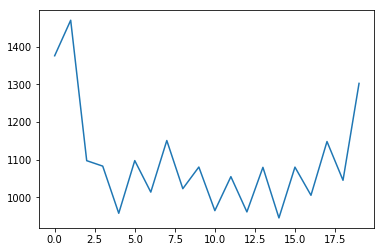

In [31]:
plt.plot(eff)